# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

## Preparación

In [38]:
df = pd.read_csv('taxi.csv', parse_dates=['datetime'])

In [39]:
df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [41]:
df.isna().sum()

datetime      0
num_orders    0
dtype: int64

In [42]:
df.set_index('datetime', inplace=True)

In [43]:
df_hourly=df.resample('1H').sum()

C:\Users\gerar\AppData\Local\Temp\ipykernel_9788\2142476799.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly=df.resample('1H').sum()


## Análisis

In [44]:
df_hourly.index.is_monotonic_increasing

True

<Axes: xlabel='datetime'>

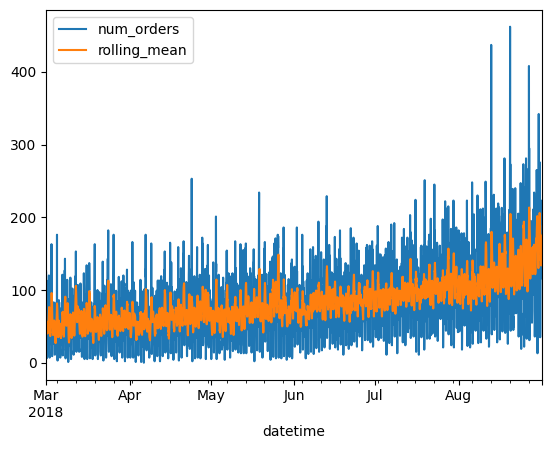

In [45]:
df_hourly['rolling_mean'] = df_hourly.rolling(10).mean()
df_hourly.plot()

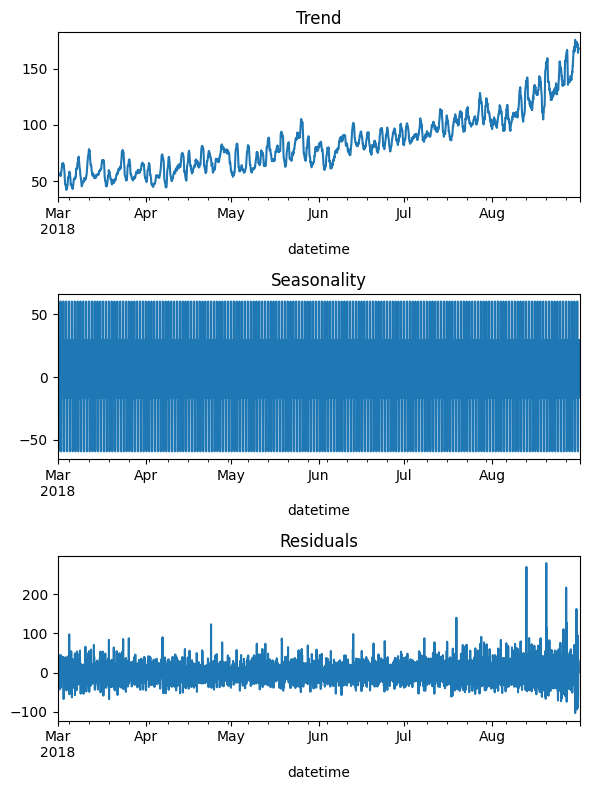

In [46]:
decomposed = seasonal_decompose(df_hourly['num_orders'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Podemos ver que la serie de tiempo desglosada, en tendencia que hay una tendencia a la alta a largo plazo, es decir que los pedido de taxis han aumentado a partir de la segunda mitad de junio, en el caso de estacionalidad podemos ver que los patrones son repetitivos a lo largo del tiempo.

## Formación

In [47]:
def make_features(df_hourly, max_lag):
   
    df_hourly['year'] = df_hourly.index.year
    df_hourly['month'] = df_hourly.index.month
    df_hourly['day'] = df_hourly.index.day
    df_hourly['dayofweek'] = df_hourly.index.dayofweek
    df_hourly['hour'] = df_hourly.index.hour
    
    for lag in range(1, max_lag + 1):
        df_hourly['lag_{}'.format(lag)] = df_hourly['num_orders'].shift(lag)
    df_hourly['rolling_mean_4'] = df_hourly['num_orders'].shift().rolling(4).mean()
    df_hourly['rolling_mean_12'] = df_hourly['num_orders'].shift().rolling(12).mean()  # ← NUEVA
    df_hourly['rolling_mean_24'] = df_hourly['num_orders'].shift().rolling(24).mean()  # ← NUEVA
    return df_hourly


In [48]:
df_hourly = make_features(df_hourly,5)
df_hourly.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_4,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,4,66.0,71.0,85.0,124.0,NaN,86.50,NaN,NaN
2018-03-01 05:00:00,6,NaN,2018,3,1,3,5,43.0,66.0,71.0,85.0,124.0,66.25,NaN,NaN
2018-03-01 06:00:00,12,NaN,2018,3,1,3,6,6.0,43.0,66.0,71.0,85.0,46.50,NaN,NaN
2018-03-01 07:00:00,15,NaN,2018,3,1,3,7,12.0,6.0,43.0,66.0,71.0,31.75,NaN,NaN
2018-03-01 08:00:00,34,NaN,2018,3,1,3,8,15.0,12.0,6.0,43.0,66.0,19.00,NaN,NaN


In [49]:
df_hourly.dropna(inplace=True)

In [50]:
df_hourly

,num_orders,rolling_mean,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean_4,rolling_mean_12,rolling_mean_24
datetime,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,65.9,2018,3,2,4,0,58.0,113.0,66.0,61.0,45.0,74.50,56.583333,56.833333
2018-03-02 01:00:00,120,71.3,2018,3,2,4,1,90.0,58.0,113.0,66.0,61.0,81.75,61.583333,55.416667
2018-03-02 02:00:00,75,74.5,2018,3,2,4,2,120.0,90.0,58.0,113.0,66.0,95.25,68.916667,56.875000
2018-03-02 03:00:00,64,76.5,2018,3,2,4,3,75.0,120.0,90.0,58.0,113.0,85.75,71.166667,57.041667
2018-03-02 04:00:00,20,71.2,2018,3,2,4,4,64.0,75.0,120.0,90.0,58.0,87.25,71.000000,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,166.6,2018,8,31,4,19,207.0,217.0,197.0,116.0,133.0,184.25,163.416667,164.875000
2018-08-31 20:00:00,154,162.9,2018,8,31,4,20,136.0,207.0,217.0,197.0,116.0,189.25,170.916667,167.541667
2018-08-31 21:00:00,159,162.1,2018,8,31,4,21,154.0,136.0,207.0,217.0,197.0,178.50,168.583333,168.041667


## Prueba

In [51]:
temp, test = train_test_split(df_hourly, shuffle=False, test_size=0.1, random_state=12345)
train, valid = train_test_split(temp, shuffle=False, test_size=0.1, random_state=12345)

In [52]:
features_train = train.drop(['num_orders'],axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'],axis=1)
target_valid = valid['num_orders']

In [53]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
print(mean_squared_error(target_train, predictions_train)**0.5)
predictions_valid = model.predict(features_valid)
print(mean_squared_error(target_valid, predictions_valid)**0.5)

25.93759801915531
36.278178476999756


In [54]:
model = RandomForestRegressor(n_estimators=200, max_depth=50)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
predictions_valid = model.predict(features_valid)
print(np.sqrt(mean_squared_error(target_valid, predictions_valid)))

30.703295275634964


In [55]:
model = RandomForestRegressor(random_state=12345)
param_grid = {'n_estimators':[100,150,200], 
             'max_depth': [2,3,4,5],
             'min_samples_leaf':[3,6]}
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                          cv=5)
grid_search.fit(features_train, target_train)


,estimator,RandomForestR...m_state=12345)
,param_grid,"{'max_depth': [2, 3, ...], 'min_samples_leaf': [3, 6], 'n_estimators': [100, 150, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,150


In [56]:
grid_search.best_params_
print(grid_search.best_params_)
print(np.sqrt(abs(grid_search.best_score_)))

{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 150}
23.92508412618033


In [57]:
predictions = grid_search.best_estimator_.predict(features_valid)
print(np.sqrt(mean_squared_error(target_valid, predictions)))

37.54104884561236


In [58]:
model = CatBoostRegressor(loss_function='RMSE', iterations=2000, random_seed=12345, verbose=False, learning_rate=0.02)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
print(mean_squared_error(target_train, predictions_train)**0.5)
predictions_valid = model.predict(features_valid)
print(mean_squared_error(target_valid, predictions_valid)**0.5)

10.654551831170597
28.479046423452058


In [59]:
model = lgb.LGBMRegressor(num_iterations = 2000, objective='regression', random_state= 12345, learning_rate=0.02)
model.fit(features_train, target_train)
predictions_train = model.predict(features_train)
print(mean_squared_error(target_train, predictions_train)**0.5)
predictions_valid = model.predict(features_valid)
print(mean_squared_error(target_valid, predictions_valid)**0.5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1979
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 13
[LightGBM] [Info] Start training from score 74.948538
4.480003972492119
27.915546840005558


#### Fase de validación 

In [60]:
features_temp = temp.drop(['num_orders'],axis=1)
target_temp = temp['num_orders']

In [61]:
model = LinearRegression()
model.fit(features_temp, target_temp)
predictions_temp = model.predict(features_temp)
predictions_test = model.predict(features_test)
print(mean_squared_error(target_test, predictions_test)**0.5)

44.461247352377015


In [62]:
model = lgb.LGBMRegressor(num_iterations = 2000, objective='regression', random_state= 12345, learning_rate=0.02)
model.fit(features_temp, target_temp)
predictions_temp = model.predict(features_temp)
predictions_test = model.predict(features_test)
print(mean_squared_error(target_test, predictions_test)**0.5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 13
[LightGBM] [Info] Start training from score 78.451417
40.783494037252915


Se puede observar que el mejor modelo en el caso de las series temporales que LGBMregressor ya que tenía el valor mas bajo de la metrica RECM, hubo algunos cambios de esta metrica cuando se puso a prueba con el dataset de test, sin embargo quedo bajo el maximo de 48, es importante mencionar que mas allá de la modificación de hiper parametros y de la selección del modelo, tuve que cmabir la función que enriquecía los parametros adhiriendo la columna hora puesto que los patrones de los taxis son muy dependientes de las horas del día.  

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [X]  El código no tiene errores
- [X]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [ ]  	
Los datos han sido descargados y preparados.
- [X]  Se ha realizado el paso 2: los datos han sido analizados
- [X]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [X]  Se han evaluado los modelos. Se expuso una conclusión
- [X] La *RECM* para el conjunto de prueba no es más de 48